In [1]:
import os
import sys
ROOT = os.getenv('BONNER_ROOT_PATH')
sys.path.append(ROOT)

from model_evaluation.results.predicting_brain_data.brain_map import *
from model_features.models.models import load_model_dict
from model_evaluation.utils import get_activations_iden
from config import CACHE
from matplotlib.colors import LinearSegmentedColormap

def process_data(data):

    data = data.drop_vars(["subject",'region','name']).to_array()
    data.x.values = data.x.values.astype(int)
    data.y.values = data.y.values.astype(int)
    data.z.values = data.z.values.astype(int)
    data = data.drop('variable').squeeze()
    
    return data


def get_scores_iden(activations_iden, region):
    models = []
    scores_path = os.path.join(CACHE,'encoding_scores')
    for iden in os.listdir(scores_path):
        if all(sub in iden for sub in [activations_iden, region]):
            models.append(iden)
    return sorted(models)

# Plotting brain maps

In [2]:
dataset = 'naturalscenes'
alexnet_layers = ['alexnet_conv1', 'alexnet_conv3' , 'alexnet_conv5', 
'alexnet_untrained_conv1', 'alexnet_untrained_conv3', 'alexnet_untrained_conv5']

activations_iden_1 = get_activations_iden(load_model_dict('expansion_10000'),'naturalscenes')
scores_iden_1 = get_scores_iden(activations_iden_1, 'general')[0]

for layer_name in alexnet_layers:
    
    activations_iden_2 = get_activations_iden(load_model_dict(layer_name),'naturalscenes')
    scores_iden_2 = get_scores_iden(activations_iden_2, 'general')[0]
    print(scores_iden_2)

    

    plot_brain_map(data= None,
                subject= None, 
                cond = 'difference_of_means',
                scores_path = os.path.join(CACHE,'encoding_scores',scores_iden_1),
                scores_path_2 = os.path.join(CACHE,'encoding_scores',scores_iden_2),
                name=f'expansion_vs_{layer_name}',
                vmax = 0.3)
    plt.clf()

alexnet_conv1_1_layers_64_features_naturalscenes_general


2023-10-02 15:46:35.519 | DEBUG    | model_evaluation.results.predicting_brain_data.brain_map:download_from_s3:114 - Using previously downloaded file at /data/atlas/brain_map/allen2021.natural_scenes/nsddata/ppdata/subj01/func1pt8mm/brainmask.nii.gz instead of downloading nsddata/ppdata/subj01/func1pt8mm/brainmask.nii.gz from S3 bucket natural-scenes-dataset
2023-10-02 15:46:35.534 | DEBUG    | model_evaluation.results.predicting_brain_data.brain_map:download_from_s3:114 - Using previously downloaded file at /data/atlas/brain_map/allen2021.natural_scenes/nsddata/ppdata/subj01/transforms/func1pt8-to-MNI.nii.gz instead of downloading nsddata/ppdata/subj01/transforms/func1pt8-to-MNI.nii.gz from S3 bucket natural-scenes-dataset
2023-10-02 15:46:39.375 | DEBUG    | model_evaluation.results.predicting_brain_data.brain_map:download_from_s3:114 - Using previously downloaded file at /data/atlas/brain_map/allen2021.natural_scenes/nsddata/ppdata/subj02/func1pt8mm/brainmask.nii.gz instead of downl

alexnet_conv3_3_layers_384_features_naturalscenes_general


2023-10-02 15:49:45.518 | DEBUG    | model_evaluation.results.predicting_brain_data.brain_map:download_from_s3:114 - Using previously downloaded file at /data/atlas/brain_map/allen2021.natural_scenes/nsddata/ppdata/subj01/func1pt8mm/brainmask.nii.gz instead of downloading nsddata/ppdata/subj01/func1pt8mm/brainmask.nii.gz from S3 bucket natural-scenes-dataset
2023-10-02 15:49:45.537 | DEBUG    | model_evaluation.results.predicting_brain_data.brain_map:download_from_s3:114 - Using previously downloaded file at /data/atlas/brain_map/allen2021.natural_scenes/nsddata/ppdata/subj01/transforms/func1pt8-to-MNI.nii.gz instead of downloading nsddata/ppdata/subj01/transforms/func1pt8-to-MNI.nii.gz from S3 bucket natural-scenes-dataset
2023-10-02 15:49:55.770 | DEBUG    | model_evaluation.results.predicting_brain_data.brain_map:download_from_s3:114 - Using previously downloaded file at /data/atlas/brain_map/allen2021.natural_scenes/nsddata/ppdata/subj02/func1pt8mm/brainmask.nii.gz instead of downl

alexnet_conv5_5_layers_256_features_naturalscenes_general_best_layer


2023-10-02 15:52:48.506 | DEBUG    | model_evaluation.results.predicting_brain_data.brain_map:download_from_s3:114 - Using previously downloaded file at /data/atlas/brain_map/allen2021.natural_scenes/nsddata/ppdata/subj02/func1pt8mm/brainmask.nii.gz instead of downloading nsddata/ppdata/subj02/func1pt8mm/brainmask.nii.gz from S3 bucket natural-scenes-dataset
2023-10-02 15:52:48.515 | DEBUG    | model_evaluation.results.predicting_brain_data.brain_map:download_from_s3:114 - Using previously downloaded file at /data/atlas/brain_map/allen2021.natural_scenes/nsddata/ppdata/subj02/transforms/func1pt8-to-MNI.nii.gz instead of downloading nsddata/ppdata/subj02/transforms/func1pt8-to-MNI.nii.gz from S3 bucket natural-scenes-dataset
2023-10-02 15:52:52.297 | DEBUG    | model_evaluation.results.predicting_brain_data.brain_map:download_from_s3:114 - Using previously downloaded file at /data/atlas/brain_map/allen2021.natural_scenes/nsddata/ppdata/subj03/func1pt8mm/brainmask.nii.gz instead of downl

alexnet_untrained_conv1_1_layers_64_features_naturalscenes_general


2023-10-02 15:54:48.310 | DEBUG    | model_evaluation.results.predicting_brain_data.brain_map:download_from_s3:114 - Using previously downloaded file at /data/atlas/brain_map/allen2021.natural_scenes/nsddata/ppdata/subj02/func1pt8mm/brainmask.nii.gz instead of downloading nsddata/ppdata/subj02/func1pt8mm/brainmask.nii.gz from S3 bucket natural-scenes-dataset
2023-10-02 15:54:48.319 | DEBUG    | model_evaluation.results.predicting_brain_data.brain_map:download_from_s3:114 - Using previously downloaded file at /data/atlas/brain_map/allen2021.natural_scenes/nsddata/ppdata/subj02/transforms/func1pt8-to-MNI.nii.gz instead of downloading nsddata/ppdata/subj02/transforms/func1pt8-to-MNI.nii.gz from S3 bucket natural-scenes-dataset
2023-10-02 15:54:52.127 | DEBUG    | model_evaluation.results.predicting_brain_data.brain_map:download_from_s3:114 - Using previously downloaded file at /data/atlas/brain_map/allen2021.natural_scenes/nsddata/ppdata/subj03/func1pt8mm/brainmask.nii.gz instead of downl

alexnet_untrained_conv3_3_layers_384_features_naturalscenes_general_best_layer


2023-10-02 15:56:47.987 | DEBUG    | model_evaluation.results.predicting_brain_data.brain_map:download_from_s3:114 - Using previously downloaded file at /data/atlas/brain_map/allen2021.natural_scenes/nsddata/ppdata/subj02/func1pt8mm/brainmask.nii.gz instead of downloading nsddata/ppdata/subj02/func1pt8mm/brainmask.nii.gz from S3 bucket natural-scenes-dataset
2023-10-02 15:56:47.996 | DEBUG    | model_evaluation.results.predicting_brain_data.brain_map:download_from_s3:114 - Using previously downloaded file at /data/atlas/brain_map/allen2021.natural_scenes/nsddata/ppdata/subj02/transforms/func1pt8-to-MNI.nii.gz instead of downloading nsddata/ppdata/subj02/transforms/func1pt8-to-MNI.nii.gz from S3 bucket natural-scenes-dataset
2023-10-02 15:56:51.783 | DEBUG    | model_evaluation.results.predicting_brain_data.brain_map:download_from_s3:114 - Using previously downloaded file at /data/atlas/brain_map/allen2021.natural_scenes/nsddata/ppdata/subj03/func1pt8mm/brainmask.nii.gz instead of downl

alexnet_untrained_conv5_5_layers_256_features_naturalscenes_general


2023-10-02 15:58:46.765 | DEBUG    | model_evaluation.results.predicting_brain_data.brain_map:download_from_s3:114 - Using previously downloaded file at /data/atlas/brain_map/allen2021.natural_scenes/nsddata/ppdata/subj02/func1pt8mm/brainmask.nii.gz instead of downloading nsddata/ppdata/subj02/func1pt8mm/brainmask.nii.gz from S3 bucket natural-scenes-dataset
2023-10-02 15:58:46.773 | DEBUG    | model_evaluation.results.predicting_brain_data.brain_map:download_from_s3:114 - Using previously downloaded file at /data/atlas/brain_map/allen2021.natural_scenes/nsddata/ppdata/subj02/transforms/func1pt8-to-MNI.nii.gz instead of downloading nsddata/ppdata/subj02/transforms/func1pt8-to-MNI.nii.gz from S3 bucket natural-scenes-dataset
2023-10-02 15:58:50.547 | DEBUG    | model_evaluation.results.predicting_brain_data.brain_map:download_from_s3:114 - Using previously downloaded file at /data/atlas/brain_map/allen2021.natural_scenes/nsddata/ppdata/subj03/func1pt8mm/brainmask.nii.gz instead of downl

<Figure size 640x480 with 0 Axes>

# Getting subset of voxels for brainmap

In [ ]:
# def process_subject(subject):
#     expansion_mni = transform_volume_to_mni(
#         data=reshape_dataarray_to_brain(
#             data=process_data(expansion_scores_ds),
#             subject=subject,
#             resolution=resolution,
#         ),
#         subject=subject,
#         source_space=f"func{resolution[:-2]}",
#         interpolation_type=interpolation_type,
#     )
#     expansion_scores[:, subject] = expansion_mni.flatten()

In [9]:
def string_add(a, b, c):
    
    return a + b + c
    
    
def get_xyz(ds):
    
    ds = ds.assign_coords(x=ds['x'].astype(int).astype(str))
    ds = ds.assign_coords(y=ds['y'].astype(int).astype(str))
    ds = ds.assign_coords(z=ds['z'].astype(int).astype(str))
    
    return ds.assign_coords(xyz=xr.apply_ufunc(string_add, ds['x'], ds['y'], ds['z'], vectorize=True))

import xarray as xr
import numpy as np
from scipy import stats


expansion_scores = xr.open_dataset('/data/atlas/model_scores_final/expansion_model_rgb_test_mp_3_layers_10000_features_naturalscenes/expansion_model_rgb_test_mp_3_layers_10000_features_naturalscenes_general_test_ridge(alpha=1000)')
alexnet_scores = xr.open_dataset('/data/atlas/model_scores_final/alexnet_mp_5_layers_256_features_naturalscenes/alexnet_mp_5_layers_256_features_naturalscenes_general_test_ridge(alpha=100000)')

    

def get_subset(expansion_scores,alexnet_scores,regions,subject, diff=False):

        expansion_subject_scores = expansion_scores.where((expansion_scores.subject == subject),drop=True)
        alexnet_subject_scores = alexnet_scores.where((alexnet_scores.subject == subject),drop=True)

        coords_list = []
        
        for region in regions:

            path = f'/data/rgautha1/cache/bonner-caching/neural-dimensionality/data/dataset=allen2021.natural_scenes/resolution=1pt8mm.preprocessing=fithrf_GLMdenoise_RR/roi={region}/preprocessed/z_score=session.average_across_reps=True/subject={subject}.nc'
            region_coords = xr.open_dataset(path)
            var_name = f'allen2021.natural_scenes.preprocessing=fithrf_GLMdenoise_RR.roi={region}.z_score=session.average_across_reps=True.subject={subject}'
            region_coords = region_coords.rename({var_name:'vals'})
            coords_list.append(region_coords)        
        
        all_region_coords = xr.concat(coords_list, dim='neuroid')
        
        
        all_region_coords = get_xyz(all_region_coords)
        expansion_subject_scores = get_xyz(expansion_subject_scores)
        alexnet_subject_scores = get_xyz(alexnet_subject_scores)
        
        
        if not diff:
            expansion_subject_scores = expansion_subject_scores.where(
                expansion_subject_scores.neuroid.xyz.isin([all_region_coords.xyz]),drop=True)
            
            alexnet_subject_scores = alexnet_subject_scores.where(
                alexnet_subject_scores.neuroid.xyz.isin([all_region_coords.xyz]),drop=True)
            
        else:
            
            expansion_subject_scores = expansion_subject_scores.where(~
                expansion_subject_scores.neuroid.xyz.isin([all_region_coords.xyz]),drop=True)

            alexnet_subject_scores = alexnet_subject_scores.where(~
                alexnet_subject_scores.neuroid.xyz.isin([all_region_coords.xyz]),drop=True)
            
        return expansion_subject_scores, alexnet_subject_scores


# Statistical analysis

In [21]:



expansion_scores_ds = xr.open_dataset('/data/atlas/model_scores_final/expansion_model_rgb_mp_3_layers_10000_features_naturalscenes/expansion_model_rgb_mp_3_layers_10000_features_naturalscenes_general_ridgecv')
expansion_scores = np.zeros((mni_shape,8))

alexnet_scores_ds = xr.open_dataset('/data/atlas/model_scores_final/alexnet_u_conv5_mp_5_layers_256_features_naturalscenes/alexnet_u_conv5_mp_5_layers_256_features_naturalscenes_general_ridgecv')
alexnet_scores = np.zeros((mni_shape,8))


for subject in range(8):      
        

    expansion_mni = transform_volume_to_mni(
        data=reshape_dataarray_to_brain(
            data=process_subject(expansion_scores_ds),
            subject=subject,
            resolution=resolution,
        ),
        subject=subject,
        source_space=f"func{resolution[:-2]}",
        interpolation_type=interpolation_type,
    )
    expansion_scores[:,subject] = expansion_mni.flatten()
    
    
    alexnet_mni = transform_volume_to_mni(
        data=reshape_dataarray_to_brain(
            data=process_subject(alexnet_scores_ds),
            subject=subject,
            resolution=resolution,
        ),
        subject=subject,
        source_space=f"func{resolution[:-2]}",
        interpolation_type=interpolation_type,
    )
    alexnet_scores[:,subject] = alexnet_mni.flatten()


FileNotFoundError: [Errno 2] No such file or directory: b'/data/atlas/model_scores_final/expansion_model_rgb_mp_3_layers_10000_features_naturalscenes/expansion_model_rgb_mp_3_layers_10000_features_naturalscenes_general_ridgecv'

In [11]:
# import multiprocessing as mp

# expansion_scores_ds = xr.open_dataset('/data/atlas/model_scores_final/expansion_model_rgb_test_mp_3_layers_10000_features_naturalscenes/expansion_model_rgb_test_mp_3_layers_10000_features_naturalscenes_general_test_ridge(alpha=1000)')

# manager = mp.Manager()
# expansion_scores = manager.Array('d', mni_shape * 8)  # Shared array for expansion_scores

# pool = mp.Pool(processes=8)
# pool.map(process_subject, range(8))
# pool.close()
# pool.join()

# expansion_scores = np.frombuffer(expansion_scores.get_obj(), dtype=np.float64).reshape(mni_shape, 8)

In [10]:
def filter_zero_rows(arr1, arr2):
    # Get a boolean mask indicating rows where all column values are zero in both arrays
    mask = np.all(arr1 == 0, axis=1) & np.all(arr2 == 0, axis=1)
    
    # Filter the arrays based on the mask
    filtered_arr1 = arr1[~mask]
    filtered_arr2 = arr2[~mask]
    
    return filtered_arr1, filtered_arr2


# Perform paired t-test
t_statistic, p_value = stats.ttest_rel(expansion_scores, alexnet_scores, axis=1)

th = 0.001
sig_voxels = np.where(p_value <= th)[0]
all_voxels = np.where(~np.isnan(p_value))[0]
print(f'percentage of voxels with p-value < {th}:',round(len(sig_voxels)/len(all_voxels),2))

percentage of voxels with p-value < 0.001: 0.03


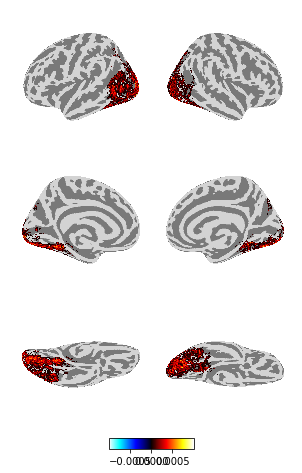

In [11]:
def set_values_to_zero(arr, th=0.001):
    arr[arr > th] = 0
    return arr

# Set values smaller than 0.001 to zero
masked_p_values = set_values_to_zero(p_value)
masked_p_values_brain = np.nan_to_num(masked_p_values.reshape((182, 218, 182)))

volume = convert_ndarray_to_nifti1image(masked_p_values_brain)

fig, _ = nilearn.plotting.plot_img_on_surf(
    volume,
    views=["lateral", "medial", "ventral"],
    hemispheres=["left", "right"],
    colorbar=True,
    inflate=True,
    surf_mesh='fsaverage',
    threshold=np.finfo(np.float32).resolution,
    symmetric_cbarbool='auto',
)
fig.savefig('significant_p_values',dpi=300)

# Plotting Brain for Visualization

In [9]:
resolution = '1pt8mm'      
interpolation_type = 'nearest'
subject = 0
colors = ['White','darkorange']
custom_cmap = LinearSegmentedColormap.from_list('CustomMap', colors) 


### V1-V4

2023-09-13 12:32:40.730 | DEBUG    | model_evaluation.results.predicting_brain_data.brain_map:download_from_s3:114 - Using previously downloaded file at /data/atlas/brain_map/allen2021.natural_scenes/nsddata/ppdata/subj01/func1pt8mm/brainmask.nii.gz instead of downloading nsddata/ppdata/subj01/func1pt8mm/brainmask.nii.gz from S3 bucket natural-scenes-dataset
2023-09-13 12:32:40.738 | DEBUG    | model_evaluation.results.predicting_brain_data.brain_map:download_from_s3:114 - Using previously downloaded file at /data/atlas/brain_map/allen2021.natural_scenes/nsddata/ppdata/subj01/transforms/func1pt8-to-MNI.nii.gz instead of downloading nsddata/ppdata/subj01/transforms/func1pt8-to-MNI.nii.gz from S3 bucket natural-scenes-dataset


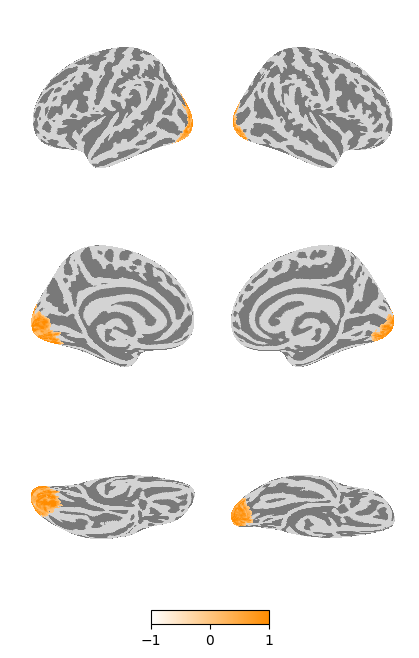

In [10]:
regions = ['V1','V2','V3','V4']

scores_list = []
for region in regions:
    data = xr.open_dataset(f'/data/atlas/.cache/encoding_scores/expansion_model_3_layers_10_features_naturalscenes_{region}',
                           engine='h5netcdf')
    data = data.where(data.subject == subject,drop=True)
    scores_list.append(data)
scores = xr.concat(scores_list, dim='neuroid')



alexnet_mni = transform_volume_to_mni(
    data=reshape_dataarray_to_brain(
        data=process_data(scores),
        subject=subject,
        resolution=resolution,
    ),
    subject=subject,
    source_space=f"func{resolution[:-2]}",
    interpolation_type=interpolation_type,
)




brain_region = np.where(alexnet_mni > 0, 1,0)
#brain_region = np.where(alexnet_mni > 0, 0,0)
volume = convert_ndarray_to_nifti1image(brain_region)

fig, _ = nilearn.plotting.plot_img_on_surf(
    volume,
    views=["lateral", "medial", "ventral"],
    hemispheres=["left", "right"],
    colorbar=True,
    inflate=True,
    surf_mesh='fsaverage',
    threshold=np.finfo(np.float32).resolution,
    symmetric_cbarbool='auto',
    cmap = custom_cmap, 
    vmax = 1
)
fig.savefig(f'just_brain_{regions}',dpi=300,transparent=True)

### general

2023-09-13 12:35:56.851 | DEBUG    | model_evaluation.results.predicting_brain_data.brain_map:download_from_s3:114 - Using previously downloaded file at /data/atlas/brain_map/allen2021.natural_scenes/nsddata/ppdata/subj01/func1pt8mm/brainmask.nii.gz instead of downloading nsddata/ppdata/subj01/func1pt8mm/brainmask.nii.gz from S3 bucket natural-scenes-dataset
2023-09-13 12:35:56.859 | DEBUG    | model_evaluation.results.predicting_brain_data.brain_map:download_from_s3:114 - Using previously downloaded file at /data/atlas/brain_map/allen2021.natural_scenes/nsddata/ppdata/subj01/transforms/func1pt8-to-MNI.nii.gz instead of downloading nsddata/ppdata/subj01/transforms/func1pt8-to-MNI.nii.gz from S3 bucket natural-scenes-dataset


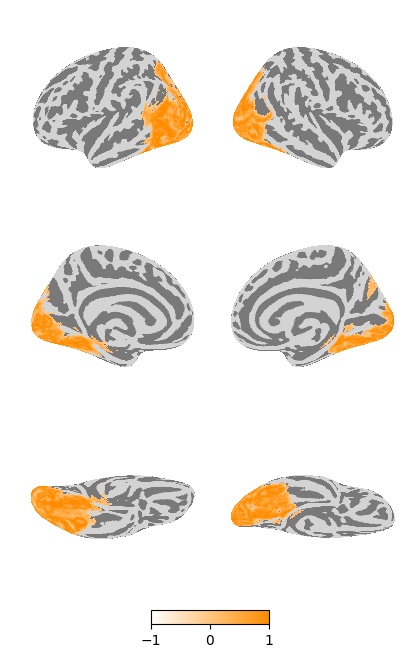

In [11]:
regions = ['general']



scores_list = []
for region in regions:
    data = xr.open_dataset(f'/data/atlas/.cache/encoding_scores/alexnet_conv5_5_layers_256_features_naturalscenes_general',engine='h5netcdf')
    data = data.where(data.subject == subject,drop=True)
    scores_list.append(data)
scores = xr.concat(scores_list, dim='neuroid')




alexnet_mni = transform_volume_to_mni(
    data=reshape_dataarray_to_brain(
        data=process_data(scores),
        subject=subject,
        resolution=resolution,
    ),
    subject=subject,
    source_space=f"func{resolution[:-2]}",
    interpolation_type=interpolation_type,
)





brain_region = np.where(alexnet_mni > 0, 1,0)
volume = convert_ndarray_to_nifti1image(brain_region)

fig, _ = nilearn.plotting.plot_img_on_surf(
    volume,
    views=["lateral", "medial", "ventral"],
    hemispheres=["left", "right"],
    colorbar=True,
    inflate=True,
    surf_mesh='fsaverage',
    threshold=np.finfo(np.float32).resolution,
    symmetric_cbarbool='auto',
    cmap = custom_cmap, 
    vmax = 1
)
fig.savefig(f'just_brain_{regions}',dpi=300, transparent=True)